In [3]:
!pip install opencv-python

  Using cached opencv_python-4.7.0.72-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.8 MB)


In [4]:
DATA_ORG = "certain"
GEOMETRY = "circles"

In [5]:
import cv2
from pathlib import Path
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import json

test = None

with open("../make_data_organizations/splits/" + DATA_ORG + '.json', 'r') as f:
    test = json.load(f)
test = test["test"]

data = {"Name": [], "Predicted": [], "Real": []}

# 16 is batch size was used while training models
BATCHES = len(test) // 16
REMAIN = len(test) % 16

In [6]:
batch_size = 16
for batch_count in range(BATCHES):
    if batch_count == BATCHES - 1:
        batch_size = REMAIN
    for i in range(batch_size):
        file = Path("predicted_masks/" + DATA_ORG + "_" + GEOMETRY + f"/output{batch_count}_{i}.png")
        # print(str(file))

        img = cv2.imread(str(file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # (T, img) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)

        contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        roi = pd.read_csv("../../data/all_rois/" + str(Path(test[batch_count * 16 + i]).stem) + ".roi2", header = None)

        data["Name"].append(file.stem)
        data["Predicted"].append(len(contours))
        data["Real"].append(len(roi))
    
df = pd.DataFrame(data)
df.to_csv("all_csv/" + DATA_ORG + "_" + GEOMETRY + ".csv", index=False, sep=";")

In [7]:
import json
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

from sklearn.linear_model import LinearRegression
import numpy as np

manually = list(df["Real"])
automatically = list(df["Predicted"])

print(manually)
print(automatically)

maximum = max(max(manually), max(automatically))
minimum = min(min(manually), min(automatically))

x = np.array(automatically).reshape(-1,1)
y = np.array(manually).reshape(-1,1)

linreg = LinearRegression().fit(x,y)

[14, 25, 10, 20, 21, 20, 14, 18, 23, 23, 22, 10, 17, 10, 20, 18, 12, 17, 23, 9, 18, 22, 12, 18, 18, 9, 16, 17, 9, 24, 18, 19, 10, 8, 21, 12, 10, 8, 9, 10, 18, 20, 10, 23, 22, 10, 10, 9, 13, 10, 9, 24, 13, 21, 12, 11, 10, 14, 24, 10, 11, 18, 10, 10, 20, 23, 11, 21, 6, 23, 18, 19, 20, 20, 23, 20, 18, 14, 17, 13, 11, 19, 21, 23, 19, 10, 19, 16, 20, 18, 11, 9, 11, 16, 21, 9, 16, 9, 26, 21, 21, 11, 17, 11, 10, 19, 26, 12, 11, 18, 12, 24, 14, 11, 29, 12, 19, 11, 21, 30, 12, 19, 13, 22, 10, 9, 11, 22, 8, 10, 24, 8, 12, 19, 8, 11, 9, 20, 17, 21, 19, 21, 24, 22, 10, 12, 9, 20, 11, 10, 23, 10, 10, 21, 19, 26, 21, 17, 10, 18, 9, 9, 18, 12, 21, 18, 18, 22, 10, 20, 17, 17, 18, 21, 10, 11, 20, 20, 20, 26, 18, 19, 11, 10, 10, 22, 12, 9, 8, 9, 19, 19, 18, 9, 10, 20, 18, 7, 11, 22, 16, 20, 12, 11, 18, 11, 9, 19, 11, 10, 9, 20, 22, 22, 8, 20, 11, 12, 15, 20, 9, 10, 19, 11, 20, 10, 9, 19, 18, 10, 20, 8, 12, 19, 10, 18, 10, 23, 11, 21, 14, 10, 18, 19, 18, 10, 14, 9, 17, 23, 19, 11, 11, 21, 17, 9, 23, 18, 

In [8]:
from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score

def RMSE(t, d):
    n = len(t)
    summa = 0
    for i in range(n):
        summa += (t[i] - d[i]) ** 2
    result = np.sqrt(summa / n)
    return result

def rRMSE(t, d):
    n = len(t)
    summa = 0
    for i in range(n):
        summa += ((t[i] - d[i]) / t[i]) ** 2
    result = np.sqrt(summa / n)
    return result

def R_squared(t, d):
    n = len(t)
    t_mean = np.mean(t)
    summa1 = 0
    summa2 = 0
    for i in range(n):
        summa1 += (t[i] - d[i]) ** 2
        summa2 +=  (t[i] - t_mean) ** 2
        #print(t[i] - d[i], t[i] - t_mean)
    result = 1 - summa1 / summa2
    return result

def MAE(t, d):
    n = len(t)
    summa = 0
    for i in range(n):
        summa += abs(t[i] - d[i])
    result = summa / n
    return result
    
def MAPE(t, d):
    n = len(t)
    summa = 0
    for i in range(n):
        summa += abs((t[i] - d[i]) / t[i])
    result = summa * 100 / n
    return result

rmse = RMSE(manually, automatically)
r_rmse = rRMSE(manually, automatically)
r_squared = R_squared(manually, automatically)
mae = MAE(manually, automatically)
mape = MAPE(manually, automatically)
#print(rmse, r_rmse, r_squared)


RMSE = 1.68
rRMSE = 13.56%
R^2 = 0.9
MAE = 0.96
MAPE = 6.68


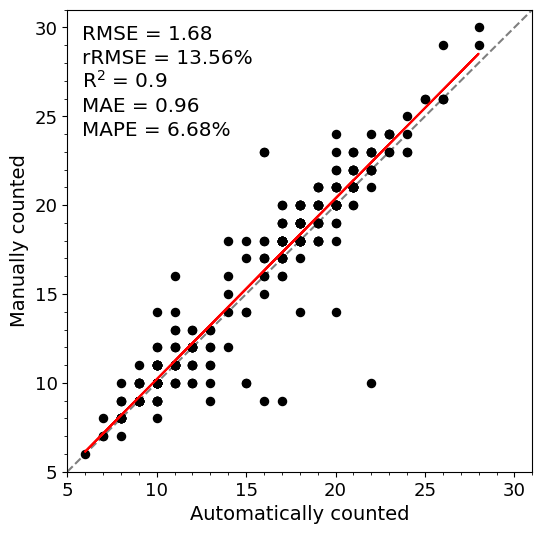

In [9]:
from matplotlib.figure import Figure

fig=plt.figure(figsize=(6,6))
ax = plt.gca()
ax.scatter(x, y, c="black", s=34)
plt.plot(np.linspace(minimum - 1, maximum + 1, num=5), np.linspace(minimum - 1, maximum + 1, num=5), linestyle='dashed', c='black', alpha=0.5)

plt.plot(x, linreg.intercept_ + linreg.coef_ * x, color='r')

ax.set_xlabel('Automatically counted', fontsize = 14)
ax.set_ylabel('Manually counted', fontsize = 14)

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))

plt.figtext(0.15, 0.83, f"RMSE = {round(rmse, 2)}", fontsize='x-large')
plt.figtext(0.15, 0.79, f"rRMSE = {round(r_rmse * 100, 2)}%", fontsize='x-large')
plt.figtext(0.15, 0.75, f"R$^2$ = {round(r_squared, 2)}", fontsize='x-large')
plt.figtext(0.15, 0.71, f"MAE = {round(mae, 2)}", fontsize='x-large')
plt.figtext(0.15, 0.67, f"MAPE = {round(mape, 2)}%", fontsize='x-large')

print(f"RMSE = {round(rmse, 2)}")
print(f"rRMSE = {round(r_rmse * 100, 2)}%")
print(f"R^2 = {round(r_squared, 2)}")
print(f"MAE = {round(mae, 2)}")
print(f"MAPE = {round(mape, 2)}")
ax.tick_params(axis='both', which='major', labelsize=13)

plt.xlim(minimum - 1, maximum + 1)
plt.ylim(minimum - 1, maximum + 1)
plt.show()

In [10]:
fig.savefig("plots/" + DATA_ORG + "_" + GEOMETRY + '.jpg', dpi=300)